In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("assets/cardio_train.csv", sep = ";").drop(columns = "id")

print(df.shape)
df.head()

(70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Disease Representation (2 A)

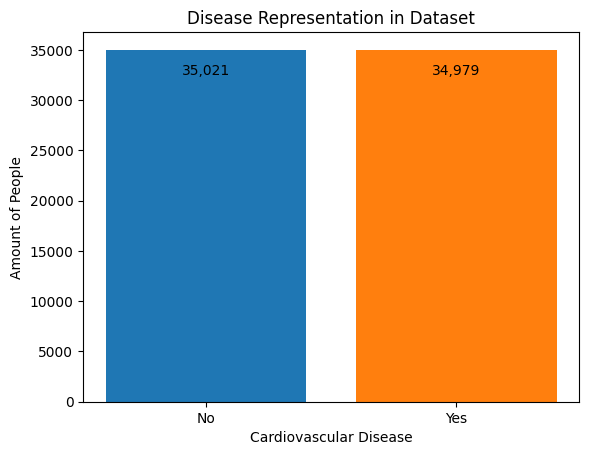

In [3]:
# dictionary of values to look at and what to call them
disease = {"No": 0, "Yes": 1}

fig, ax = plt.subplots() 

for i in disease.values(): # plot amount of each value (0, 1) in cardio
    plt.bar(x = i, height = len(df[df["cardio"] == i]))

# set amount and position of ticks based on values, and map keys to them
plt.xticks(ticks = [value for value in disease.values()], labels = disease.keys())

for p in ax.containers: # show and format values on bars
    ax.bar_label(p, labels = [f"{val:,.0f}" for val in p.datavalues], padding = -20)

# set labels
ax.set(title = "Disease Representation in Dataset", xlabel = "Cardiovascular Disease", ylabel = "Amount of People");